### Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
import sys
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tabulate import tabulate
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from deslib.dcs import OLA
# from deslib.dcs import KNORA_U, KNORA_E
from deslib.des import  KNOP, METADES
from deslib.static import SingleBest, StackedClassifier
from deslib.static import StaticSelection

c:\Users\josev\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Feature extrection

In [2]:
FEATURES_SET = {
    "feature": 1,
    "permission": 2,
    "activity": 3,
    "service_receiver": 3,
    "provider": 3,
    "service": 3,
    "intent": 4,
    "api_call": 5,
    "real_permission": 6,
    "call": 7,
    "url": 8
}


def count_feature_set(lines):
    """
    Count how many features belong to a specific set
    :param lines: features in the text file
    :return:
    """
    features_map = {x: 0 for x in range(1, 9)}
    for l in lines:
        if l != "\n":
            set = l.split("::")[0]
            features_map[FEATURES_SET[set]] += 1
    features = []
    for i in range(1, 9):
        features.append(features_map[i])
    return features


In [3]:
def read(LOAD_DATA=False):
    if LOAD_DATA:
        print("Previous data not loaded. Attempt to read data ...")
        mypath = r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton\Drebin\MetaData\feature_vectors\feature_vectors"
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

        print("Reading csv file for ground truth ...")
        ground_truth = np.loadtxt(r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton\Drebin\MetaData\sha256_family.csv", delimiter=",", skiprows=1, dtype=str)
        # print ground_truth.shape
        # families = np.unique(ground_truth[:, 1])
        # print families
        # print len(families)

        print("Reading positive and negative texts ...")
        pos = []
        neg = []
        for virus in tqdm(onlyfiles):
            if virus in ground_truth[:, 0]:
                pos.append(virus)
            else:
                #if len(neg) < 5560:
                #if len(neg) < 22240:
                    neg.append(virus)

        print("Extracting features ...")
        x = []
        y = []
        for text_file in tqdm(pos):
            sys.stdin = open("%s/%s" % (mypath, text_file))
            features = sys.stdin.readlines()
            sample = count_feature_set(features)
            x.append(sample)
            y.append(1)

        for text_file in tqdm(neg):
            sys.stdin = open("%s/%s" % (mypath, text_file))
            features = sys.stdin.readlines()
            sample = count_feature_set(features)
            x.append(sample)
            y.append(0)

        print("Data is read successfully:")
        x = np.array(x)
        y = np.array(y)
        print(x.shape, y.shape)

        print("Saving data under data_numpy directory ...")
        np.save(r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton/x_all.npy", x)
        np.save(r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton/y_all.npy", y)

        return x, y
    else:
        print("Loading previous data ...")
        x_ = np.load(r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton/x_all.npy")
        y_ = np.load(r"C:\Users\josev\Desktop\ProjetoPessoalNN\GeorgeDarminton/y_all.npy")
        print(x_.shape, y_.shape)
        # print x == x_, y == y_
        return x_, y_


def map_family_to_category(families):
    out = {}
    count = 1
    for family in families:
        out[family] = count
        count += 1
    return out


if __name__ == "__main__":
    #x, y = read(LOAD_DATA=True)
    x, y = read()

Loading previous data ...
(129013, 8) (129013,)


### Dataframe

In [4]:
x_all, y_all = read(LOAD_DATA=False)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loading previous data ...
(129013, 8) (129013,)
(103210, 8) (103210,)
(25803, 8) (25803,)


### Algorithms

In [5]:
classifiers = {
    'DecisionTree': DecisionTreeClassifier(criterion='gini'),
    'MLP': MLPClassifier(hidden_layer_sizes=(100), max_iter=1000),
    'Knn': KNeighborsClassifier(n_neighbors=7),
    'NaiveBayes': GaussianNB(),
    'BaggingDecisionTree': BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini'), n_estimators=30),
    'BaggingNaiveBayes': BaggingClassifier(estimator=GaussianNB(), n_estimators=30),
    'BaggingKnn': BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=7), n_estimators=30),
    'BaggingMLP': BaggingClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100), max_iter=1000), n_estimators=30),
    'GradientBoostedDecisionTree': GradientBoostingClassifier(n_estimators=100),
    'RandomForest': RandomForestClassifier(n_estimators=100)
}

DES = {
    "SingleBest": SingleBest,
    "StaticSelection": StaticSelection,
    "OLA": OLA,
    # "KNORAU": KNORAU,
    # "KNORAE": KNORAE,
    "KNOP": KNOP,
    "METADES": METADES
}

### Saving Time Functions

In [6]:
Accuracy = []
Precision = []
Recall = []
F1_score = []
Roc_auc = []

AcurracyDP = []
PrecisionDP = []
RecallDP = []
F1_scoreDP = []
Roc_aucDP = []

In [7]:
def CreateModel(x_all, y_all, model, modelName, balance, num_rep=1):

    model_dir = os.path.join("D:/Users/josev/Desktop/Machine-Learning-Empirical-Evaluation/TrainedModels/Unbalanced", modelName)
    os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

    global Accuracy, Precision, Recall, F1_score, Roc_auc
    global AcurracyDP, PrecisionDP, RecallDP, F1_scoreDP, Roc_aucDP

    acuracias = []
    precisoes = []
    recalls = []
    f1_scores = []
    roc_auc_scores = []


    for i in tqdm(range(num_rep)):

        if balance:
            x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all)
            smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
            x_train, y_train = smote.fit_resample(x_train, y_train)
            model_dir = os.path.join("D:/Users/josev/Desktop/Machine-Learning-Empirical-Evaluation/TrainedModels/Balanced", modelName)
            os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

        else:
            x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all)

        # Treinar o modelo no conjunto de treino
        model.fit(x_train, y_train)

        # Fazer previsões no conjunto de teste
        previsoes = model.predict(x_test)
        
        # Avaliar as métricas do modelo e armazenar na lista temporaria
        cm = confusion_matrix(y_test, previsoes)
        acuracia = accuracy_score(y_test, previsoes)
        precisao = precision_score(y_test, previsoes)
        recall = recall_score(y_test, previsoes)
        f1 = f1_score(y_test, previsoes)
        roc_auc = roc_auc_score(y_test, previsoes)
        
        acuracias.append(acuracia)
        precisoes.append(precisao)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        
        # Salva o modelo treinado
        # model_path = os.path.join(model_dir, f'model_{i+1}.joblib')
        # joblib.dump(model, model_path)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print(f'Repetição {i+1} {modelName} - Acurácia: {acuracia:.2f}, Precisão: {precisao:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC AUC: {roc_auc:.2f}')

    # # Adicionar as médias e desvios padrão às listas de métricas
    # Accuracy.append(np.mean(acuracias))
    # Precision.append(np.mean(precisoes))
    # Recall.append(np.mean(recalls))
    # F1_score.append(np.mean(f1_scores))
    # Roc_auc.append(np.mean(roc_auc_scores))

    # AcurracyDP.append(np.std(acuracias))
    # PrecisionDP.append(np.std(precisoes))
    # RecallDP.append(np.std(recalls))
    # F1_scoreDP.append(np.std(f1_scores))
    # Roc_aucDP.append(np.std(roc_auc_scores))

    # # Criar um DataFrame com as métricas
    # metrics_df = pd.DataFrame({
    #     'Accuracy': [np.mean(acuracias)],
    #     'Precision': [np.mean(precisoes)],
    #     'Recall': [np.mean(recalls)],
    #     'F1_score': [np.mean(f1_scores)],
    #     'Roc_auc': [np.mean(roc_auc_scores)],
    #     'Accuracy_std': [np.std(acuracias)],
    #     'Precision_std': [np.std(precisoes)],
    #     'Recall_std': [np.std(recalls)],
    #     'F1_score_std': [np.std(f1_scores)],
    #     'Roc_auc_std': [np.std(roc_auc_scores)]
    # })

    # # Salvar o DataFrame em um arquivo CSV
    # csv_path = os.path.join(model_dir, f'{modelName}_metrics.csv')
    # metrics_df.to_csv(csv_path, index=False)

    # print(f'Métricas salvas em {csv_path}')

In [8]:
def CreateDESModel(x_all, y_all, model, modelName, balance, num_rep=1):
    if balance:
        model_dir = os.path.join("D:/Users/josev/Desktop/Machine-Learning-Empirical-Evaluation/TrainedModels/Balanced", modelName)
    else:
        model_dir = os.path.join("D:/Users/josev/Desktop/Machine-Learning-Empirical-Evaluation/TrainedModels/Unbalanced", modelName)
    
    os.makedirs(model_dir, exist_ok=True)

    acuracias = []
    precisoes = []
    recalls = []
    f1_scores = []
    roc_auc_scores = []

    for i in tqdm(range(num_rep)):
        x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all)

        if balance:
            smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
            x_train, y_train = smote.fit_resample(x_train, y_train)

        # Train an ensemble of classifiers
        ensemble = RandomForestClassifier(n_estimators=100)
        ensemble.fit(x_train, y_train)

        # Initialize and train the DES model on the training set
        des_model = model(ensemble)
        des_model.fit(x_train, y_train)

        # Make predictions on the test set
        previsoes = des_model.predict(x_test)

        # Evaluate the metrics of the model and store them in the temporary list
        cm = confusion_matrix(y_test, previsoes)
        acuracia = accuracy_score(y_test, previsoes)
        precisao = precision_score(y_test, previsoes)
        recall = recall_score(y_test, previsoes)
        f1 = f1_score(y_test, previsoes)
        roc_auc = roc_auc_score(y_test, previsoes)

        acuracias.append(acuracia)
        precisoes.append(precisao)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # # Save the trained model
        # model_path = os.path.join(model_dir, f'model_{i+1}.joblib')
        # joblib.dump(des_model, model_path)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print(f'Repetition {i+1} - Accuracy: {acuracia:.2f}, Precision: {precisao:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC AUC: {roc_auc:.2f}')

    # # Add the means and standard deviations to the metric lists
    # Accuracy.append(np.mean(acuracias))
    # Precision.append(np.mean(precisoes))
    # Recall.append(np.mean(recalls))
    # F1_score.append(np.mean(f1_scores))
    # Roc_auc.append(np.mean(roc_auc_scores))

    # AcurracyDP.append(np.std(acuracias))
    # PrecisionDP.append(np.std(precisoes))
    # RecallDP.append(np.std(recalls))
    # F1_scoreDP.append(np.std(f1_scores))
    # Roc_aucDP.append(np.std(roc_auc_scores))

    # # Create a DataFrame with the metrics
    # metrics_df = pd.DataFrame({
    #     'Accuracy': [np.mean(acuracias)],
    #     'Precision': [np.mean(precisoes)],
    #     'Recall': [np.mean(recalls)],
    #     'F1_score': [np.mean(f1_scores)],
    #     'Roc_auc': [np.mean(roc_auc_scores)],
    #     'Accuracy_std': [np.std(acuracias)],
    #     'Precision_std': [np.std(precisoes)],
    #     'Recall_std': [np.std(recalls)],
    #     'F1_score_std': [np.std(f1_scores)],
    #     'Roc_auc_std': [np.std(roc_auc_scores)]
    # })

    # # Save the DataFrame to a CSV file
    # csv_path = os.path.join(model_dir, f'{modelName}_metrics.csv')
    # metrics_df.to_csv(csv_path, index=False)

    # print(f'Metrics saved in {csv_path}')

### Models

#### Unbalanced

  0%|          | 0/1 [00:00<?, ?it/s]

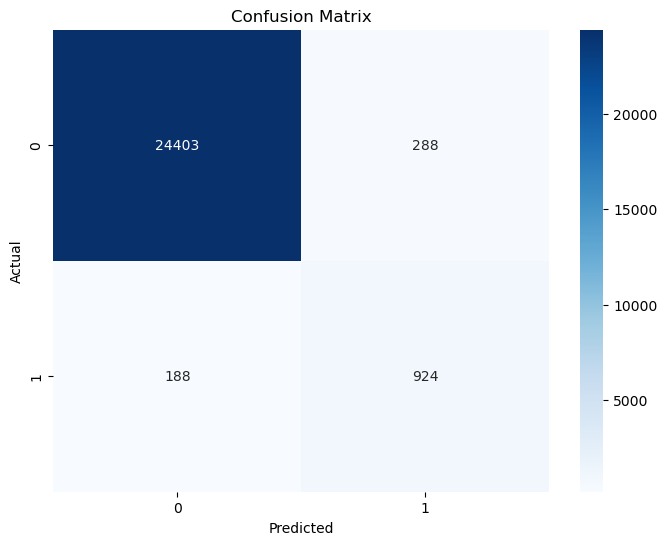

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Repetição 1 DecisionTree - Acurácia: 0.98, Precisão: 0.76, Recall: 0.83, F1-score: 0.80, ROC AUC: 0.91


  0%|          | 0/1 [00:00<?, ?it/s]

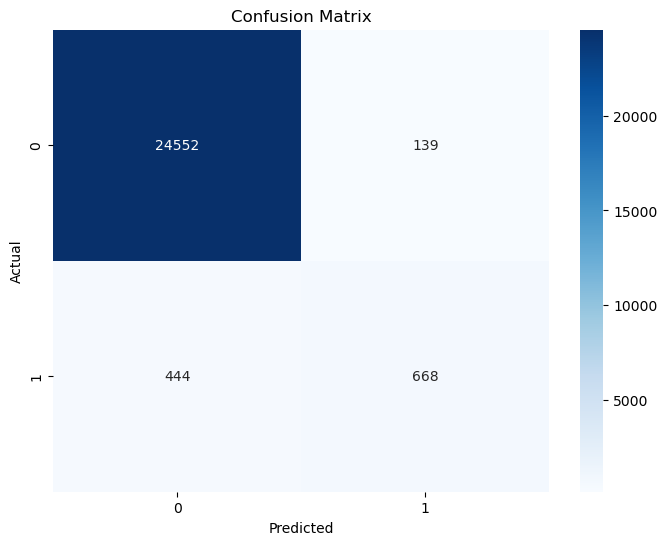

100%|██████████| 1/1 [00:39<00:00, 39.77s/it]


Repetição 1 MLP - Acurácia: 0.98, Precisão: 0.83, Recall: 0.60, F1-score: 0.70, ROC AUC: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

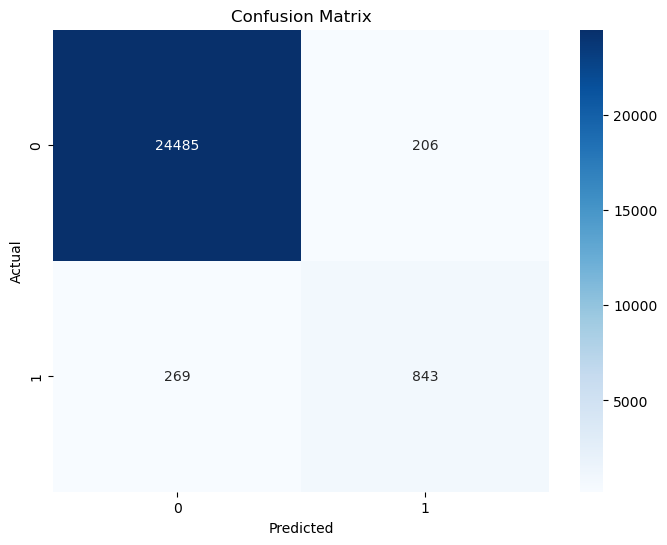

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Repetição 1 Knn - Acurácia: 0.98, Precisão: 0.80, Recall: 0.76, F1-score: 0.78, ROC AUC: 0.87


  0%|          | 0/1 [00:00<?, ?it/s]

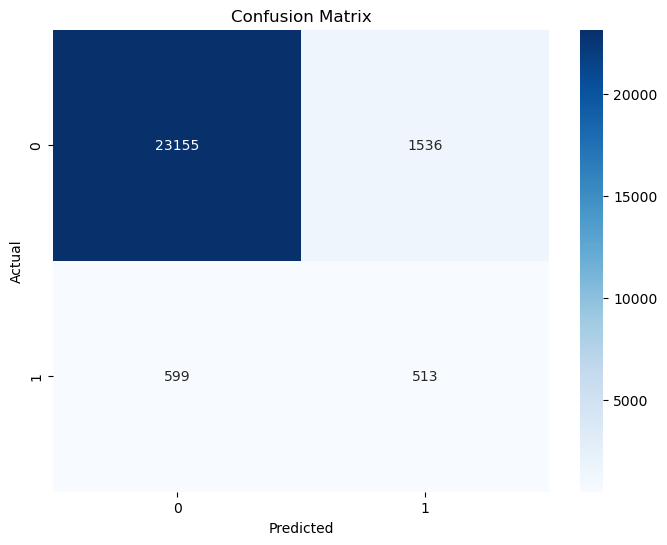

100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Repetição 1 NaiveBayes - Acurácia: 0.92, Precisão: 0.25, Recall: 0.46, F1-score: 0.32, ROC AUC: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

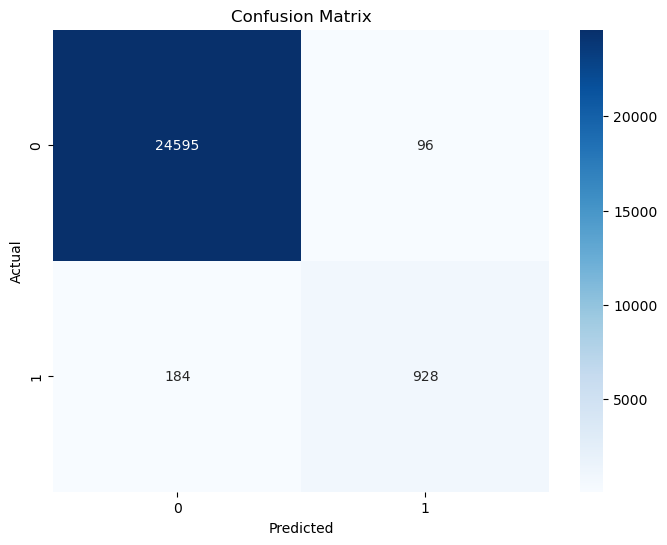

100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


Repetição 1 BaggingDecisionTree - Acurácia: 0.99, Precisão: 0.91, Recall: 0.83, F1-score: 0.87, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

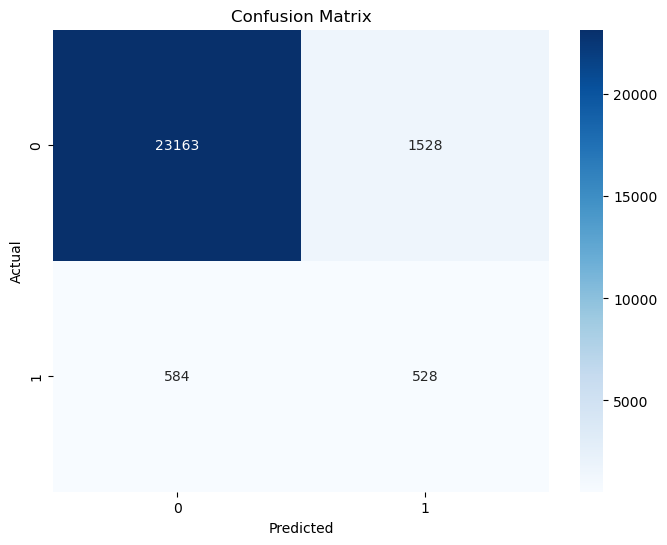

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Repetição 1 BaggingNaiveBayes - Acurácia: 0.92, Precisão: 0.26, Recall: 0.47, F1-score: 0.33, ROC AUC: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

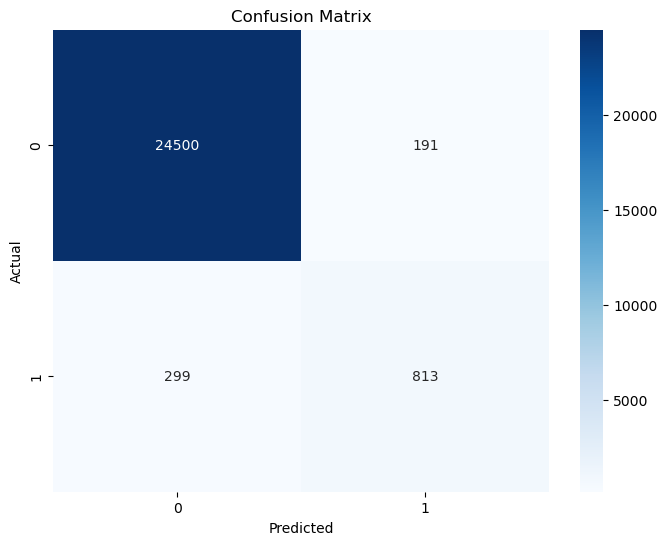

100%|██████████| 1/1 [00:47<00:00, 47.98s/it]


Repetição 1 BaggingKnn - Acurácia: 0.98, Precisão: 0.81, Recall: 0.73, F1-score: 0.77, ROC AUC: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

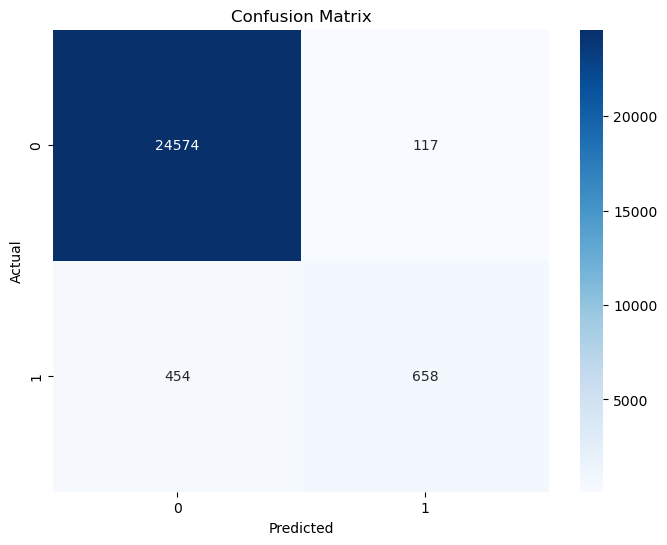

100%|██████████| 1/1 [21:33<00:00, 1293.17s/it]


Repetição 1 BaggingMLP - Acurácia: 0.98, Precisão: 0.85, Recall: 0.59, F1-score: 0.70, ROC AUC: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

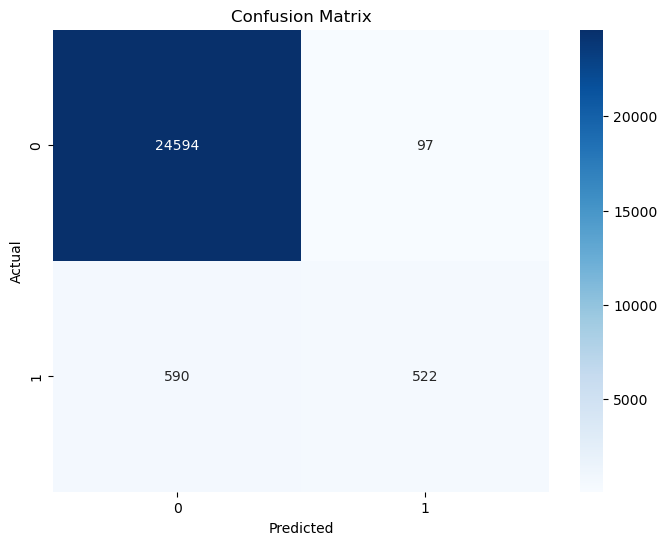

100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Repetição 1 GradientBoostedDecisionTree - Acurácia: 0.97, Precisão: 0.84, Recall: 0.47, F1-score: 0.60, ROC AUC: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

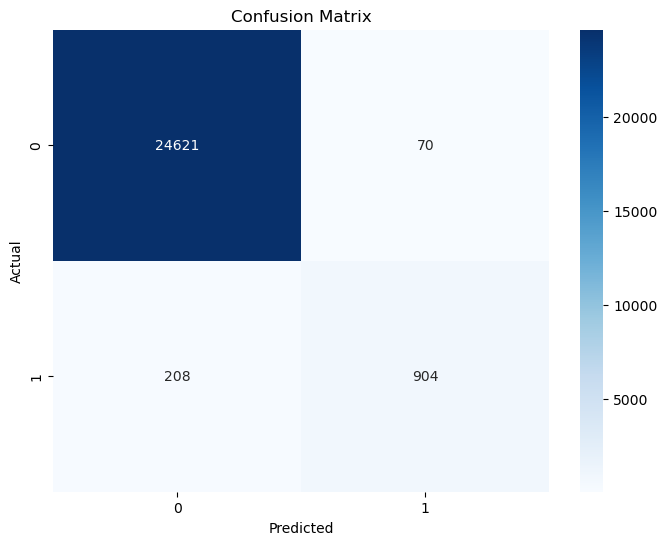

100%|██████████| 1/1 [00:04<00:00,  4.90s/it]

Repetição 1 RandomForest - Acurácia: 0.99, Precisão: 0.93, Recall: 0.81, F1-score: 0.87, ROC AUC: 0.91


In [9]:
for name, classifier in classifiers.items():
    CreateModel(x_all, y_all, classifier, name, False)

  0%|          | 0/1 [00:00<?, ?it/s]

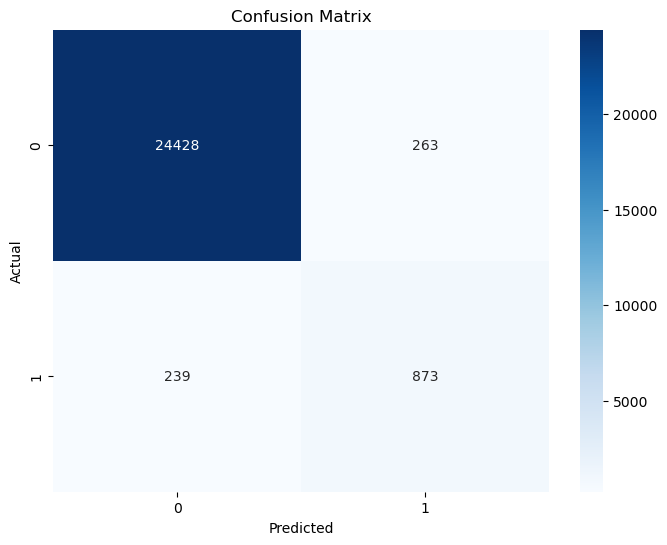

100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


Repetition 1 - Accuracy: 0.98, Precision: 0.77, Recall: 0.79, F1-score: 0.78, ROC AUC: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\josev\anaconda3\Lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


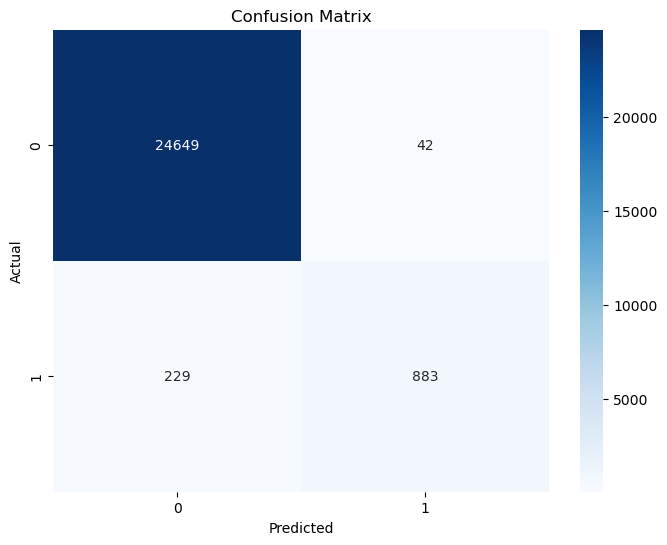

100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Repetition 1 - Accuracy: 0.99, Precision: 0.95, Recall: 0.79, F1-score: 0.87, ROC AUC: 0.90


  0%|          | 0/1 [00:00<?, ?it/s]

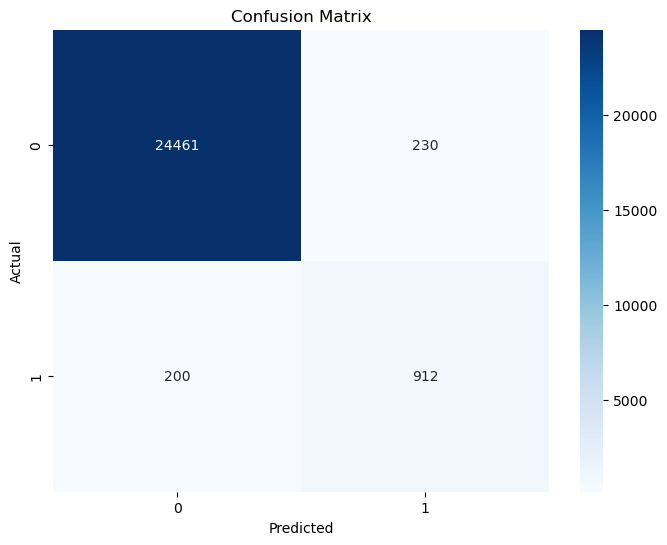

100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


Repetition 1 - Accuracy: 0.98, Precision: 0.80, Recall: 0.82, F1-score: 0.81, ROC AUC: 0.91


  0%|          | 0/1 [00:00<?, ?it/s]

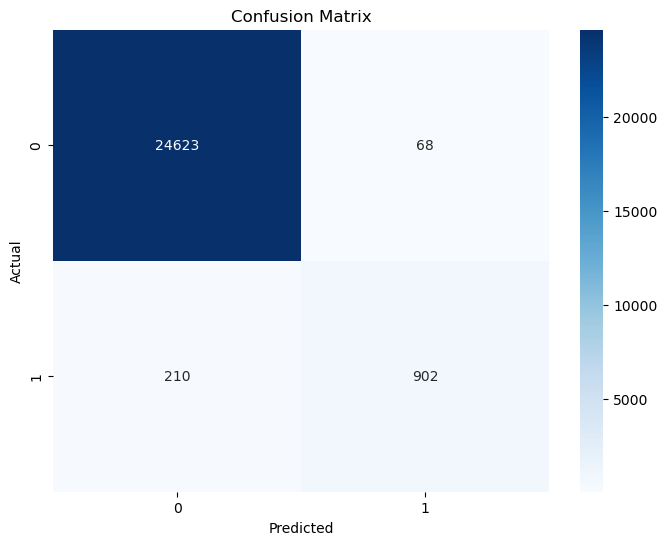

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


Repetition 1 - Accuracy: 0.99, Precision: 0.93, Recall: 0.81, F1-score: 0.87, ROC AUC: 0.90


  0%|          | 0/1 [00:00<?, ?it/s]

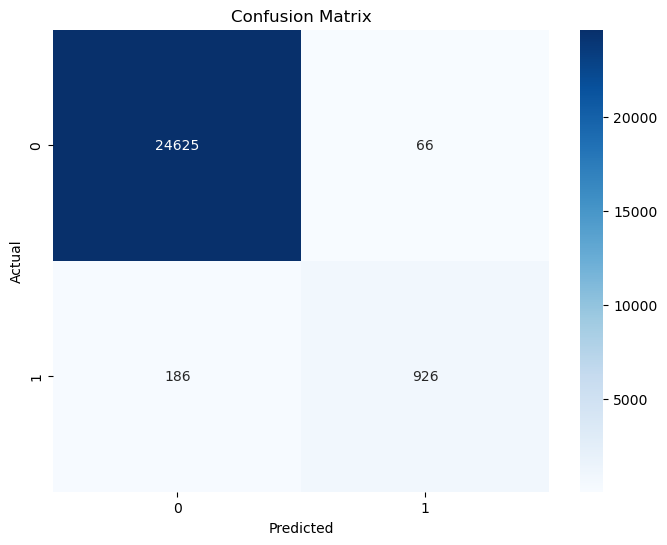

100%|██████████| 1/1 [00:29<00:00, 29.96s/it]

Repetition 1 - Accuracy: 0.99, Precision: 0.93, Recall: 0.83, F1-score: 0.88, ROC AUC: 0.92


In [10]:
for name, classifier in DES.items():
    CreateDESModel(x_all, y_all, classifier, name, balance=False)

#### Balanced

  0%|          | 0/1 [00:00<?, ?it/s]

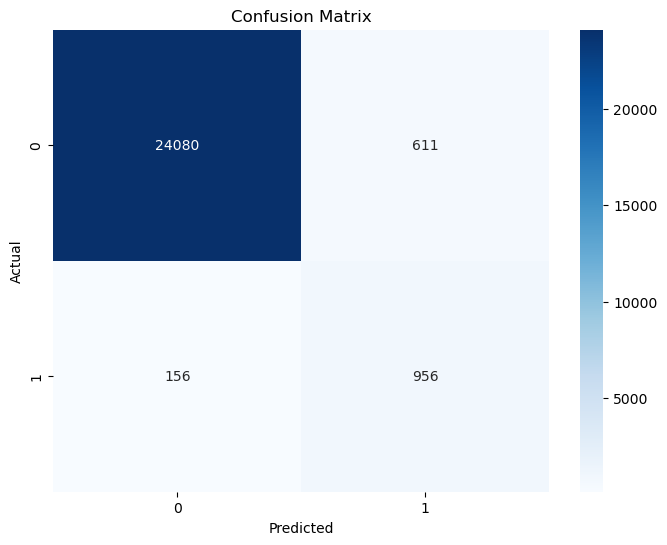

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Repetição 1 DecisionTree - Acurácia: 0.97, Precisão: 0.61, Recall: 0.86, F1-score: 0.71, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

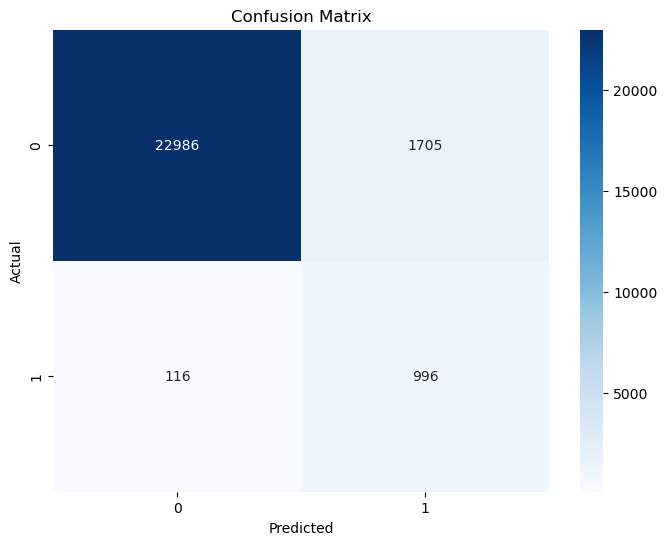

100%|██████████| 1/1 [01:18<00:00, 78.15s/it]


Repetição 1 MLP - Acurácia: 0.93, Precisão: 0.37, Recall: 0.90, F1-score: 0.52, ROC AUC: 0.91


  0%|          | 0/1 [00:00<?, ?it/s]

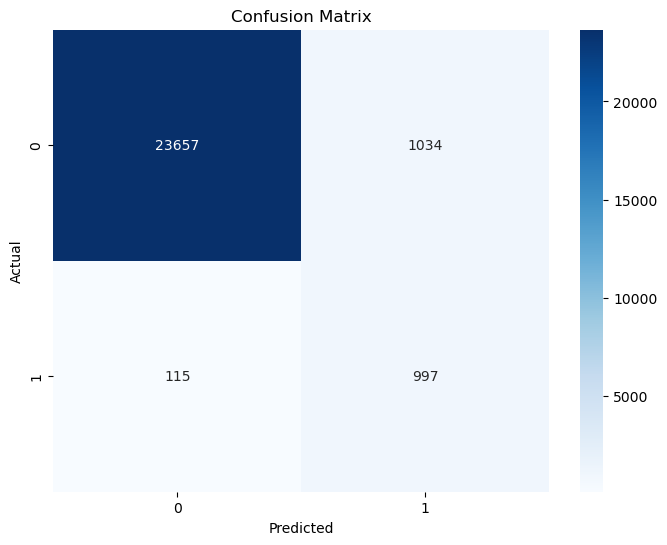

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Repetição 1 Knn - Acurácia: 0.96, Precisão: 0.49, Recall: 0.90, F1-score: 0.63, ROC AUC: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

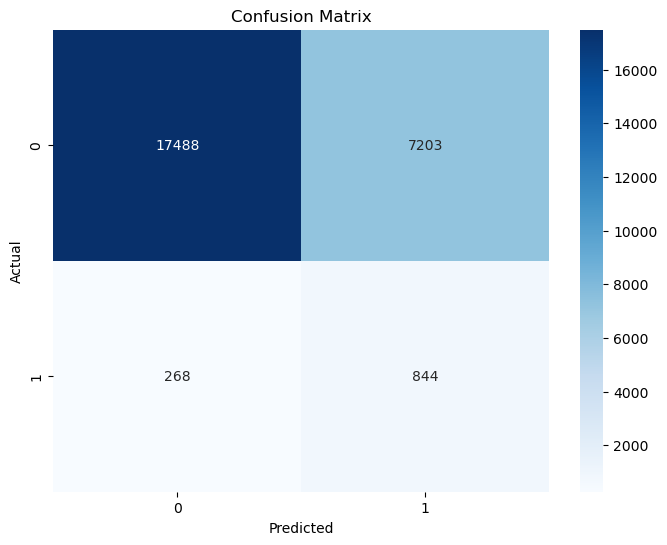

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Repetição 1 NaiveBayes - Acurácia: 0.71, Precisão: 0.10, Recall: 0.76, F1-score: 0.18, ROC AUC: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

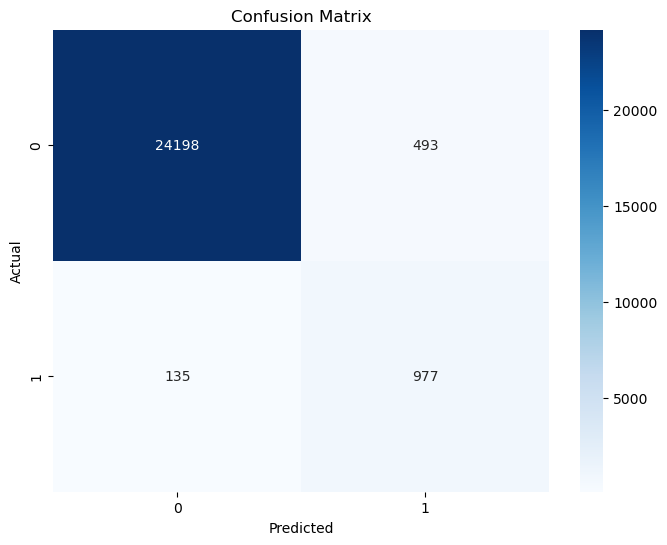

100%|██████████| 1/1 [00:08<00:00,  9.00s/it]


Repetição 1 BaggingDecisionTree - Acurácia: 0.98, Precisão: 0.66, Recall: 0.88, F1-score: 0.76, ROC AUC: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

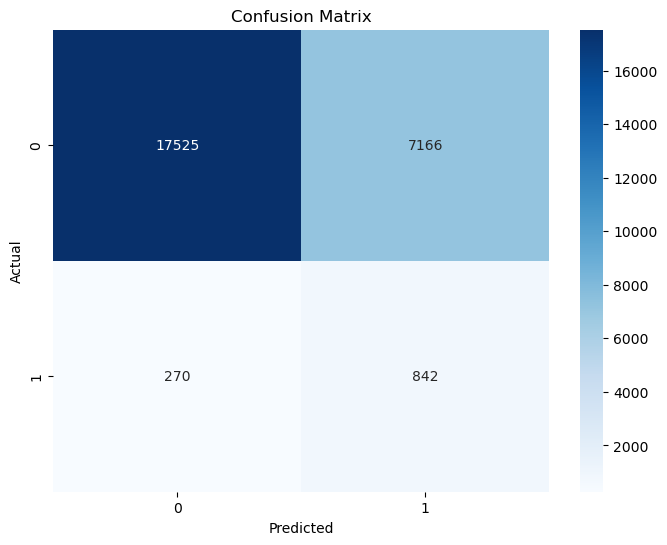

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Repetição 1 BaggingNaiveBayes - Acurácia: 0.71, Precisão: 0.11, Recall: 0.76, F1-score: 0.18, ROC AUC: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

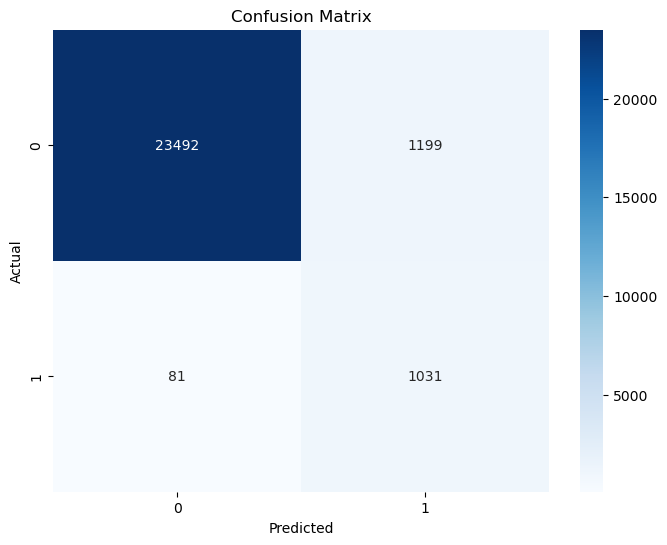

100%|██████████| 1/1 [00:58<00:00, 58.13s/it]


Repetição 1 BaggingKnn - Acurácia: 0.95, Precisão: 0.46, Recall: 0.93, F1-score: 0.62, ROC AUC: 0.94


  0%|          | 0/1 [00:00<?, ?it/s]

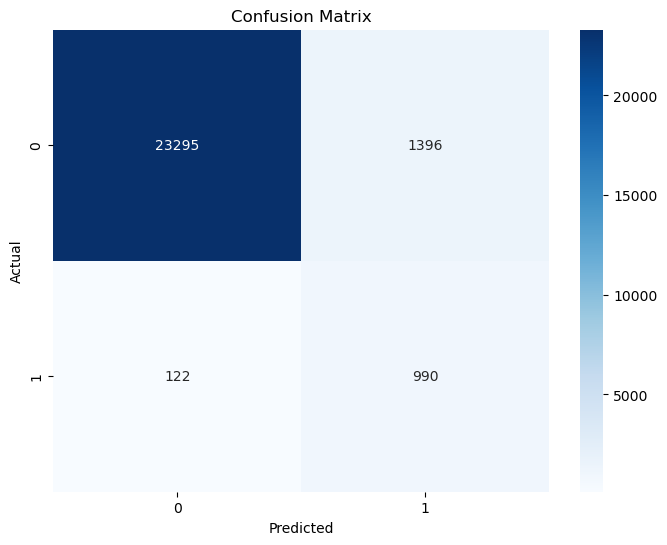

100%|██████████| 1/1 [46:25<00:00, 2785.54s/it]


Repetição 1 BaggingMLP - Acurácia: 0.94, Precisão: 0.41, Recall: 0.89, F1-score: 0.57, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

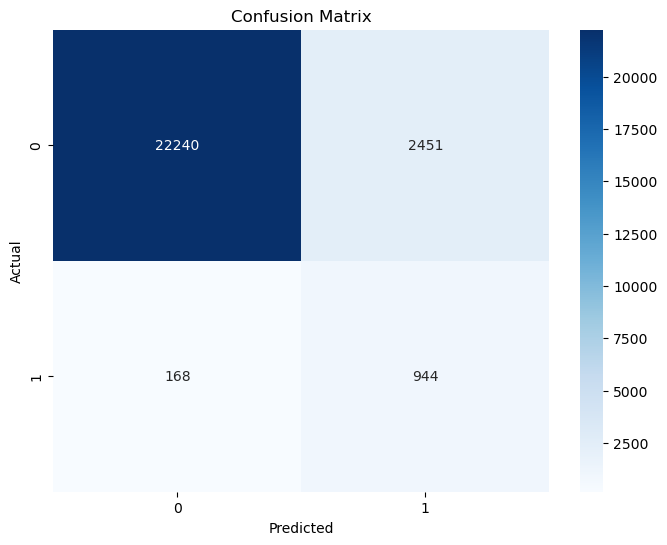

100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


Repetição 1 GradientBoostedDecisionTree - Acurácia: 0.90, Precisão: 0.28, Recall: 0.85, F1-score: 0.42, ROC AUC: 0.87


  0%|          | 0/1 [00:00<?, ?it/s]

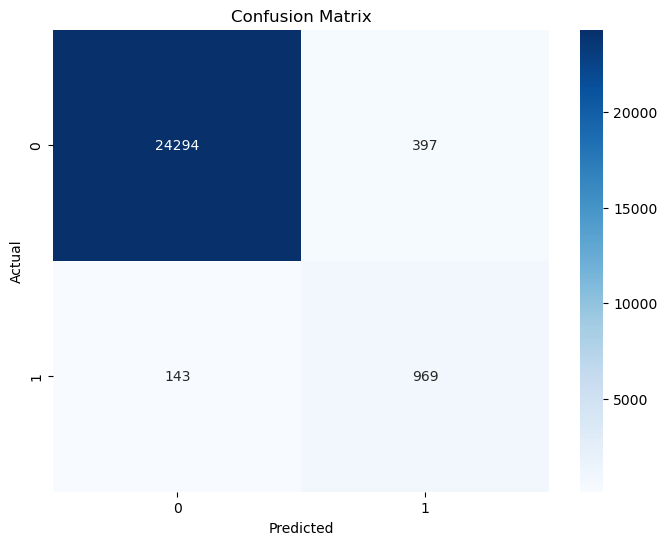

100%|██████████| 1/1 [00:10<00:00, 10.42s/it]

Repetição 1 RandomForest - Acurácia: 0.98, Precisão: 0.71, Recall: 0.87, F1-score: 0.78, ROC AUC: 0.93


In [11]:
for name, classifier in classifiers.items():
    CreateModel(x_all, y_all, classifier, name, True)

  0%|          | 0/1 [00:00<?, ?it/s]

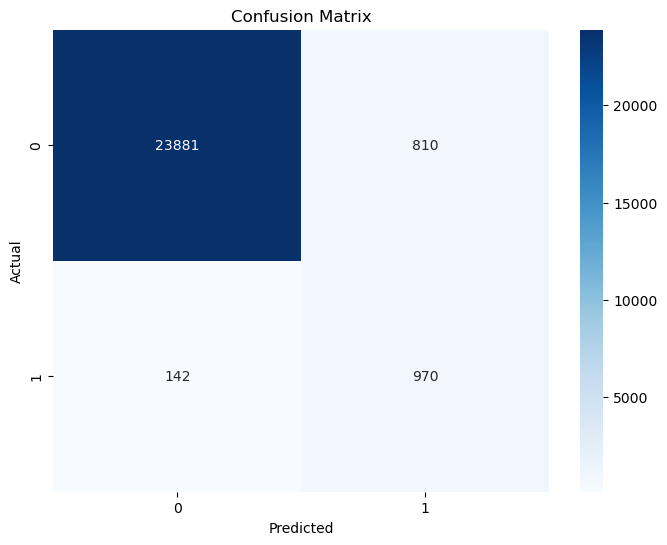

100%|██████████| 1/1 [00:14<00:00, 14.27s/it]


Repetition 1 - Accuracy: 0.96, Precision: 0.54, Recall: 0.87, F1-score: 0.67, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\josev\anaconda3\Lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


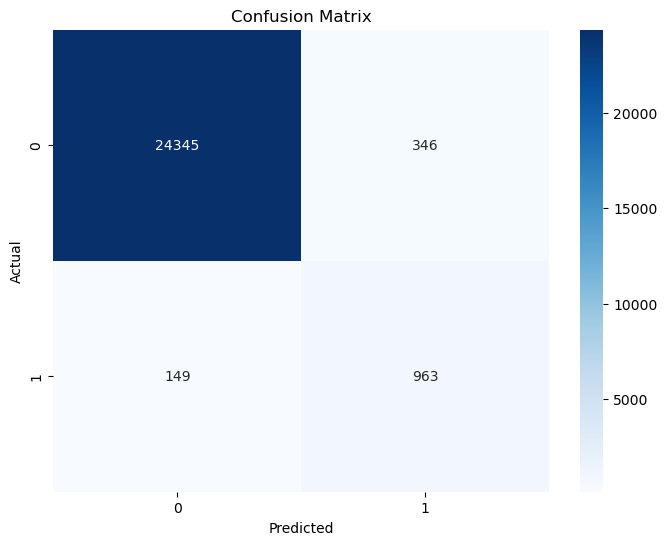

100%|██████████| 1/1 [00:15<00:00, 15.84s/it]


Repetition 1 - Accuracy: 0.98, Precision: 0.74, Recall: 0.87, F1-score: 0.80, ROC AUC: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

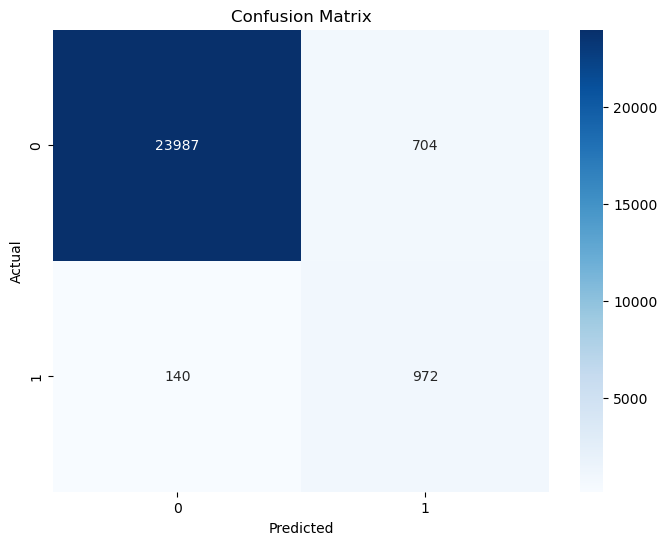

100%|██████████| 1/1 [00:14<00:00, 14.58s/it]


Repetition 1 - Accuracy: 0.97, Precision: 0.58, Recall: 0.87, F1-score: 0.70, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\josev\anaconda3\Lib\site-packages\deslib\des\base.py:177: RuntimeWarning: invalid value encountered in divide
  predicted_proba = w_votes / w_votes.sum(axis=1)[:, None]


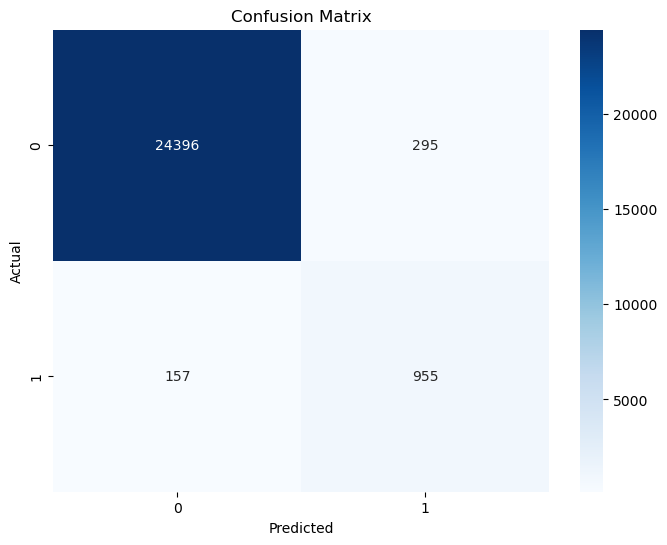

100%|██████████| 1/1 [00:19<00:00, 19.42s/it]


Repetition 1 - Accuracy: 0.98, Precision: 0.76, Recall: 0.86, F1-score: 0.81, ROC AUC: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

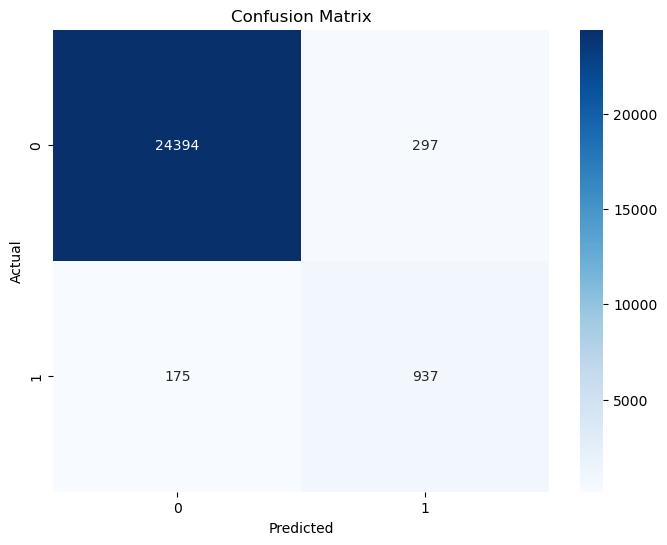

100%|██████████| 1/1 [01:23<00:00, 83.49s/it]

Repetition 1 - Accuracy: 0.98, Precision: 0.76, Recall: 0.84, F1-score: 0.80, ROC AUC: 0.92


In [12]:
for name, classifier in DES.items():
    CreateDESModel(x_all, y_all, classifier, name, balance=True)

### Results

In [13]:

# def consolidate_metrics(base_dir, class_name):
#     # Define the directory path
#     class_dir = os.path.join(base_dir, class_name)
    
#     # Create an empty dataframe to store all results
#     consolidated_df = pd.DataFrame()
    
#     # Loop through each folder in the class directory
#     for model_dir in os.listdir(class_dir):
#         model_path = os.path.join(class_dir, model_dir)
        
#         # Check if it's a directory
#         if os.path.isdir(model_path):
#             # Look for the metrics CSV file
#             for file in os.listdir(model_path):
#                 if file.endswith('_metrics.csv'):
#                     # Read the CSV file
#                     csv_path = os.path.join(model_path, file)
#                     df = pd.read_csv(csv_path)
                    
#                     # Add a column for the model name
#                     df['Model'] = model_dir
                    
#                     # Concatenate the dataframe
#                     consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)
    
#     # Save the consolidated dataframe to a new CSV file
#     consolidated_csv_path = os.path.join(base_dir, f"{class_name}_consolidated_metrics.csv")
#     consolidated_df.to_csv(consolidated_csv_path, index=False)
#     print(f"Consolidated metrics saved to: {consolidated_csv_path}")

# # Define the base directory
# base_directory = r"D:\ModelosTreinadosMLEE"

# # Consolidate metrics for Balanced and Unbalanced classes
# consolidate_metrics(base_directory, "Balanced")
# consolidate_metrics(base_directory, "Unbalanced")

In [14]:
# import os
# import pandas as pd

# def consolidate_metrics(base_dir, class_name):
#     # Define the directory path
#     class_dir = os.path.join(base_dir, class_name)
    
#     # Create an empty dataframe to store all results
#     consolidated_df = pd.DataFrame()
    
#     # Loop through each folder in the class directory
#     for model_dir in os.listdir(class_dir):
#         model_path = os.path.join(class_dir, model_dir)
        
#         # Check if it's a directory
#         if os.path.isdir(model_path):
#             # Look for the metrics CSV file
#             for file in os.listdir(model_path):
#                 if file.endswith('_metrics.csv'):
#                     # Read the CSV file
#                     csv_path = os.path.join(model_path, file)
#                     df = pd.read_csv(csv_path)
                    
#                     # Add a column for the model name
#                     df['Model'] = model_dir
                    
#                     # Concatenate the dataframe
#                     consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)
    
#     return consolidated_df

# def df_to_latex_table(df, class_name):
#     # Reorder columns to place 'Model' at the front
#     cols = ['Model'] + [col for col in df if col != 'Model']
#     df = df[cols]

#     # Generate LaTeX table code
#     latex_table = df.to_latex(index=False, float_format="%.4f", column_format='|'.join(['l']*len(df.columns)))

#     # Wrap the table with LaTeX table environment
#     latex_code = f"""
# \\begin{{table}}[h!]
#     \\centering
#     \\caption{{Metrics for {class_name} models}}
#     \\label{{tab:{class_name}_metrics}}
#     {latex_table}
# \\end{{table}}
# """

#     return latex_code

# def save_latex_table(base_dir, class_name, latex_code):
#     # Define the output path
#     output_path = os.path.join(base_dir, f"{class_name}_metrics_table.tex")
    
#     # Save the LaTeX code to a .tex file
#     with open(output_path, 'w') as f:
#         f.write(latex_code)
    
#     print(f"LaTeX table saved to: {output_path}")

# # Define the base directory
# base_directory = r"D:\ModelosTreinadosMLEE"

# # Consolidate metrics for Balanced and Unbalanced classes
# for class_name in ["Balanced", "Unbalanced"]:
#     df = consolidate_metrics(base_directory, class_name)
#     latex_code = df_to_latex_table(df, class_name)
#     save_latex_table(base_directory, class_name, latex_code)
